## ETL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [3]:
# Load the labeled data
good_examples = pd.read_csv('./InDaS Labeled/good_period_2024_01_03.csv')
good_examples

bad_examples = pd.read_csv('./InDaS Labeled/bad_period_2024_01_06.csv')
bad_examples

all_good_segments = []
all_bad_segments = []

In [4]:
# Apply the indicator function to create a new column
good_examples['indicator'] = good_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_good = good_examples.index[good_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_good.append(len(good_examples))


# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_good)-1):
    good_segment = good_examples.iloc[start_indices_good[i]:start_indices_good[i + 1]]
    all_good_segments.append(good_segment)

print("Total Good Cutting Data:", len(all_good_segments))
print("Shape of Segment 1:", all_good_segments[0].shape)
print("Shape of Torque Data:", all_good_segments[0]['Torque'].shape)


Total Good Cutting Data: 4552
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [5]:
# Apply the indicator function to create a new column
bad_examples['indicator'] = bad_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_bad = bad_examples.index[bad_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_bad.append(len(bad_examples))

# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_bad)-1):
    segment = bad_examples.iloc[start_indices_bad[i]:start_indices_bad[i + 1]]
    all_bad_segments.append(segment)

print("Total Bad Cutting Data:", len(all_bad_segments))
print("Shape of Segment 1:", all_bad_segments[0].shape)
print("Shape of Torque Data:", all_bad_segments[0]['Torque'].shape)


Total Bad Cutting Data: 1937
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


## Convert Time-Series into Spectogram Features

### STFT Spectogram Features

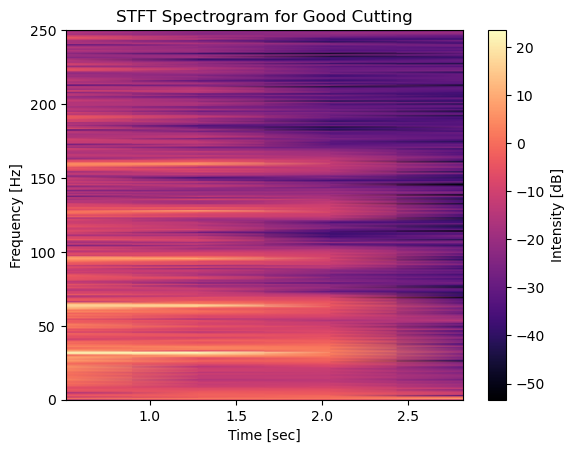

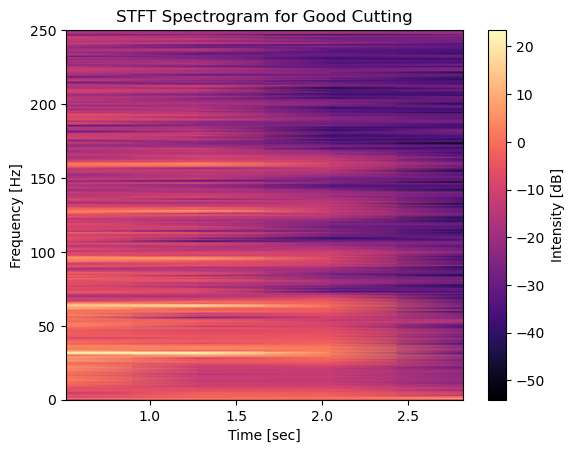

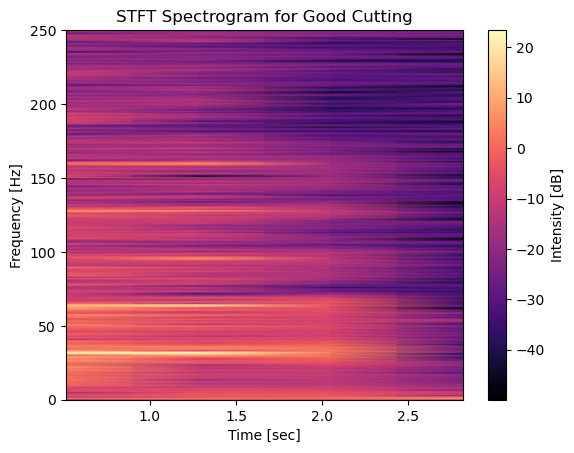

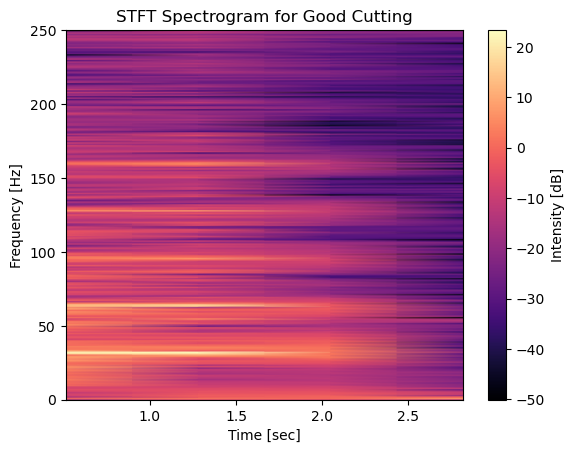

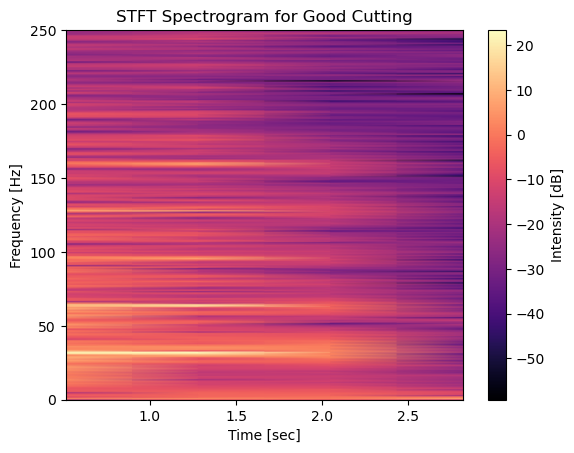

In [6]:
from scipy.signal import spectrogram
import random

good_stft_features = []
bad_stft_features = []

def compute_stft_spectrogram(data, fs=500.0, nperseg=512, noverlap=128, nfft=512, cmap='magma'):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    return Sxx

    fig = plt.figure()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap=cmap)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]', ticks=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
    plt.title('STFT Spectrogram for Bad Cutting')
    plt.show()
    #fig.savefig(f'/home/admin-anedunga/Desktop/InDas_Template/figures and graphs/good_cutting_stft{random.randint(1, 9)}.png', dpi=fig.dpi)
    return Sxx

# Plot the spectrogram of the first segment
# Sample number 4540
MAX_SAMPLES_GOOD = 4540
# Sample number 1936
MAX_SAMPLES_BAD = 1936

#MAX_SAMPLES_GOOD = 5
#MAX_SAMPLES_BAD = 5

for i in range(MAX_SAMPLES_GOOD):
    good_cutting_stft = np.asarray(all_good_segments[i]['Torque'])
    good_stft = compute_stft_spectrogram(good_cutting_stft)
    good_stft_features.append(good_stft)

   
for i in range(MAX_SAMPLES_BAD):
    bad_cutting_stft = np.asarray(all_bad_segments[i]['Torque'])
    bad_stft = compute_stft_spectrogram(bad_cutting_stft)
    bad_stft_features.append(bad_stft)




## Undersample Classes to Balance Them

### STFT Features

In [7]:

SAMPLES_FOR_TRAINING = 1500
balanced_good_stft_features = np.array(good_stft_features[:SAMPLES_FOR_TRAINING])
balanced_bad_stft_features = np.array(bad_stft_features[:SAMPLES_FOR_TRAINING])

validation_good_stft_features = np.array(good_stft_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_GOOD])
validation_bad_stft_features = np.array(bad_stft_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_BAD])

validation_good_stft_labels = np.ones(validation_good_stft_features.shape[0])
validation_bad_stft_labels = np.zeros(validation_bad_stft_features.shape[0])

validation_stft_features = np.concatenate((validation_good_stft_features, validation_bad_stft_features), axis=0)
validation_stft_labels = np.concatenate((validation_good_stft_labels, validation_bad_stft_labels), axis=0)
print("STFT Features Val Shape:", validation_stft_features.shape)
print("Balanced_Good", balanced_good_stft_features.shape)
print("Balanced_Bad", balanced_bad_stft_features.shape)

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


## Dataloader

### STFT

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Create labels for the features
good_labels = [1] * len(balanced_good_stft_features)  # Label 1 for good torque
bad_labels = [0] * len(balanced_bad_stft_features)    # Label 0 for bad torque

# Combine features and labels
features = np.array(balanced_good_stft_features + balanced_bad_stft_features)
labels = np.array(good_labels + bad_labels)

# Custom Dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create dataset and dataloaders
dataset = MelSpectrogramDataset(features, labels)
train_size = int(0.4 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_dataset = MelSpectrogramDataset(validation_stft_features, validation_stft_labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Training Small Vision transformer

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the feature extractor
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Define the Vision Transformer configuration
config = ViTConfig.from_pretrained(model_name)
config.num_labels = 2
config.image_size = (257, 4)
config.num_channels = 1  # Set the number of channels to 1

# Initialize the model with the modified configuration
model = ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
# Modify the input layer to accept the spectrogram shape with a smaller kernel size
model.vit.embeddings.patch_embeddings.projection = nn.Conv2d(1, model.config.hidden_size, 
                                                            kernel_size=(4, 4), stride=(4, 4))
# Move model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop with loss recording
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Add channel dimension for the spectrogram

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension for the spectrogram

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 1, 16, 16]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.72 GiB of which 15.88 MiB is free. Including non-PyTorch memory, this process has 3.68 GiB memory in use. Of the allocated memory 3.30 GiB is allocated by PyTorch, and 276.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# import torch
# import torch.nn as nn
# from transformers import ASTForAudioClassification, ASTFeatureExtractor
# from torch.optim import Adam
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # Initialize the model and feature extractor
# model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
# feature_extractor = ASTFeatureExtractor.from_pretrained(model_name)
# model = ASTForAudioClassification.from_pretrained(model_name, attn_implementation="sdpa", torch_dtype=torch.float16, ignore_mismatched_sizes=True)

# # Move model to the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=0.001)

# # Training loop with loss recording
# num_epochs = 5
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for inputs, labels in tqdm(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         inputs = inputs.unsqueeze(1)  # Add channel dimension for the spectrogram

#         optimizer.zero_grad()
#         outputs = model(inputs).logits
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = 100 * correct / total
#     train_losses.append(epoch_loss)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

#     # Validation loop
#     model.eval()
#     val_running_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             inputs = inputs.unsqueeze(1)  # Add channel dimension for the spectrogram

#             outputs = model(inputs).logits
#             loss = criterion(outputs, labels)
#             val_running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_epoch_loss = val_running_loss / len(val_loader)
#     val_losses.append(val_epoch_loss)
#     val_acc = 100 * correct / total
#     print(f"Validation Accuracy: {val_acc:.2f}%")

# # Plotting the loss curves
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Curves')
# plt.legend()
# plt.show()


/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/transformers/audio_utils.py:297: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (256) may be set too low.
  warnings.warn(
  0%|          | 0/19 [00:00<?, ?it/s]


RuntimeError: Input type (float) and bias type (c10::Half) should be the same